In [44]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import nltk
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import LabelBinarizer
from nltk.corpus import stopwords
from nltk.stem.porter import PorterStemmer
from wordcloud import WordCloud,STOPWORDS
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import word_tokenize,sent_tokenize
from bs4 import BeautifulSoup
import spacy
import re,string,unicodedata
from nltk.tokenize.toktok import ToktokTokenizer
from nltk.stem import LancasterStemmer,WordNetLemmatizer
from sklearn.linear_model import LogisticRegression,SGDClassifier
from sklearn.naive_bayes import MultinomialNB
from sklearn.svm import SVC
from textblob import TextBlob
from textblob import Word
from sklearn.metrics import classification_report,confusion_matrix,accuracy_score

import os
print(os.listdir("./dataset"))
import warnings
warnings.filterwarnings('ignore')

['IMDB Labelled Sentiment Movie Review.csv']


In [45]:
dataset_name = 'IMDB Labelled Sentiment Movie Review.csv'

imdb_data=pd.read_csv(f'./dataset/{dataset_name}')
print(imdb_data.shape)
imdb_data.head(10)

(5000, 2)


,text,label
0,It's been about 14 years since Sharon Stone aw...,0
1,someone needed to make a car payment... this i...,0
2,The Guidelines state that a comment must conta...,0
3,This movie is a muddled mish-mash of clichés f...,0
4,Before Stan Laurel became the smaller half of ...,0
5,This is the best movie I've ever seen! <br /><...,1
6,The morbid Catholic writer Gerard Reve (Jeroen...,1
7,"""Semana Santa"" or ""Angel Of Death"" is a very w...",0
8,Somebody mastered the difficult task of mergin...,1
9,Why did I waste 1.5 hours of my life watching ...,0


In [46]:
imdb_data.describe()

,label
count,5000.000000
mean,0.502800
std,0.500042
min,0.000000
25%,0.000000
50%,1.000000
75%,1.000000
max,1.000000


In [47]:
imdb_data['text'].value_counts()

text
The Russian space station 'Avna' with a crew of four Russians and two Americans is threatening to re-enter the Earth's atmosphere in a matter of days. Russia asks for NASA's help in rescuing the stranded crew and NASA scrambles the space shuttle Atlantis. The NSA also have an interest in the 'Prometheus', a prototype microwave power source being tested aboard 'Avna' and organise for one of their men to be placed on the mission.<br /><br />That's the plot. Onto less important things. The space station and the shuttle are the same, blatantly obvious models used in 'Fallout', 'Memorial Day' and 'Dark Breed' (and a handful of other films, I suspect). The model effects are so obvious throughout the entire movie and make the film look very 1960s. The sets are a little better but are far too '80s for what is supposedly a brand new station built by an American company (which later comes in as part of a conspiracy to destroy 'Avna' and the 'Prometheus' and claim the insurance. The script h

# Split the Dataset

## Train Dataset

In [48]:
train_reviews=imdb_data.text[:4000]
train_sentiments=imdb_data.label[:4000]


## Test Dataset

In [49]:
test_reviews=imdb_data.text[4000:]
test_sentiments=imdb_data.label[4000:]
print(train_reviews.shape,train_sentiments.shape)
print(test_reviews.shape,test_sentiments.shape)

(4000,) (4000,)
(1000,) (1000,)


## Tokenization of text

In [50]:
tokenizer=ToktokTokenizer()

## Setting English Stopwords

In [51]:
stopword_list=nltk.corpus.stopwords.words('english')

In [52]:
#Removing the html strips
def strip_html(text):
    soup = BeautifulSoup(text, "html.parser")
    return soup.get_text()

#Removing the square brackets
def remove_between_square_brackets(text):
    return re.sub('\[[^]]*\]', '', text)

#Removing the noisy text
def denoise_text(text):
    text = strip_html(text)
    text = remove_between_square_brackets(text)
    return text

In [53]:
#Apply function on review column
imdb_data['text']=imdb_data['text'].apply(denoise_text)

In [54]:
#Define function for removing special characters
def remove_special_characters(text, remove_digits=True):
    pattern=r'[^a-zA-z0-9\s]'
    text=re.sub(pattern,'',text)
    return text

In [55]:
#Apply function on review column
imdb_data['text']=imdb_data['text'].apply(remove_special_characters)

In [56]:
#Stemming the text
def simple_stemmer(text):
    ps=nltk.porter.PorterStemmer()
    text= ' '.join([ps.stem(word) for word in text.split()])
    return text

In [57]:
#Apply function on review column
imdb_data['text']=imdb_data['text'].apply(simple_stemmer)

In [58]:
#set stopwords to english
stop=set(stopwords.words('english'))
print(stop)

{'until', 'did', 'isn', 'while', "weren't", 'i', 'she', 'by', 'having', 're', 'than', 'a', "hadn't", 'ours', 'as', 'between', 'hadn', 'do', "you're", 'most', 'is', 'why', 'more', 'how', 'them', 'any', 'd', 'nor', 'these', 'whom', 'an', 'been', 'what', "wasn't", 'weren', 'which', 'when', 'my', 'because', 'from', "hasn't", 'myself', 'shan', "you'll", 'too', 'all', 'couldn', 'me', 'further', 'doesn', 'ain', 'aren', "she's", "mustn't", 'am', 'him', 'of', "shouldn't", 'be', 'those', 've', "didn't", 'such', 'does', 'for', 'they', 'at', 'wouldn', 'above', "aren't", "couldn't", "that'll", 'both', 'theirs', 'once', "should've", 'his', 'where', 'itself', "isn't", 'we', 'you', 'herself', 'our', 'are', 'some', 'should', 'has', "shan't", 'have', 'few', 'that', 'being', 'out', 'themselves', 'hers', 'it', 'after', 'down', "wouldn't", 'into', 't', 'was', 'again', 'same', 'to', 'mustn', 'don', 'this', 'and', "doesn't", 'ourselves', 'if', 'haven', 'under', 'very', 'm', 'its', 'here', 'mightn', 'needn', 

In [59]:
#removing the stopwords
def remove_stopwords(text, is_lower_case=False):
    tokens = tokenizer.tokenize(text)
    tokens = [token.strip() for token in tokens]
    if is_lower_case:
        filtered_tokens = [token for token in tokens if token not in stopword_list]
    else:
        filtered_tokens = [token for token in tokens if token.lower() not in stopword_list]
    filtered_text = ' '.join(filtered_tokens)    
    return filtered_text

In [60]:
#Apply function on review column
imdb_data['text']=imdb_data['text'].apply(remove_stopwords)

In [61]:
#normalized train reviews
norm_train_reviews=imdb_data.text[:4000]
norm_train_reviews[0]

'14 year sinc sharon stone award viewer legcross twist mani peopl mind god know whi game basic instinct 2 sequel smashhit erotica basic instinct featur sexi stone vulner michael dougla howev fan origin might even get close thi one sinc instinct 2 pain filmmak mediocr director michael catonjon assassin legaci first filmth plot movi start car explos break right begin catherin tramel sharon stone tri look forc sexi suspect appear involv murder psychiatrist horribl david morrisey appoint examin eventu fall intim game seductionand without explan basic forc move thi instinct noth much explain sit sleazi cclass erot film sharon stone star first role time turnoff part becaus amateurish write careless direct terrifyingli low chemistri movi full vulgar dialogu even sexual menag troi scene wa cut thi wouldnt rate nc17 first entranc seri instinct compel tortureto top everyth made origin film guilti pleasur found anywher film act realli bad sharon stone ha highlight get extrem obnoxi david morrisey

In [62]:
#Normalized test reviews
norm_test_reviews=imdb_data.text[4000:]
norm_test_reviews[4005]

'thi wonder rollercoast film bear repeat pleasur view tangl live three veri differ peopl holli hunter obsess workahol produc albert brook play unprepossess brilliant journalist william hurt affabl dumb new kid block news anchorth classic love triangl emerg stunningli witti self deprec brook love hunter cours attract hurtthi film work mani level veri least brilliant comedi one liner fli thick fast view bear new harvest one may miss last time also film attract unfulfil romancebut perhap importantli film examin modern obsess physic appear ultim triumph intellect valu human attribut thi personifi meteor career success hurt charact contrast brook rel declinedespit fifteen year old film ha startingli relev messag modern news valu continu declin journalist standardsthi film classic everi sens difficult understand whi ha neglect'

In [63]:
#Count vectorizer for bag of words
cv=CountVectorizer(min_df=0,max_df=1,binary=False,ngram_range=(1,3))

#transformed train reviews
cv_train_reviews=cv.fit_transform(norm_train_reviews)

#transformed test reviews
cv_test_reviews=cv.transform(norm_test_reviews)

print('BOW_cv_train:',cv_train_reviews.shape)
print('BOW_cv_test:',cv_test_reviews.shape)

BOW_cv_train: (4000, 790034)
BOW_cv_test: (1000, 790034)


In [64]:
#Tfidf vectorizer
tv=TfidfVectorizer(min_df=0,max_df=1,use_idf=True,ngram_range=(1,3))

#transformed train reviews
tv_train_reviews=tv.fit_transform(norm_train_reviews)

#transformed test reviews
tv_test_reviews=tv.transform(norm_test_reviews)
print('Tfidf_train:',tv_train_reviews.shape)
print('Tfidf_test:',tv_test_reviews.shape)

Tfidf_train: (4000, 790034)
Tfidf_test: (1000, 790034)


In [65]:
#labeling the sentient data
lb=LabelBinarizer()

#transformed sentiment data
sentiment_data=lb.fit_transform(imdb_data['label'])
print(sentiment_data.shape)

(5000, 1)


In [66]:
#Spliting the sentiment data
train_sentiments=sentiment_data[:4000]
test_sentiments=sentiment_data[4000:]
print(train_sentiments.shape)
print(test_sentiments.shape)

(4000, 1)
(1000, 1)


In [67]:
#training the model
lr=LogisticRegression(penalty='l2',max_iter=500,C=1,random_state=42)

#Fitting the model for Bag of words
lr_bow=lr.fit(cv_train_reviews,train_sentiments)
print(lr_bow)

#Fitting the model for tfidf features
lr_tfidf=lr.fit(tv_train_reviews,train_sentiments)
print(lr_tfidf)

LogisticRegression(C=1, max_iter=500, random_state=42)
LogisticRegression(C=1, max_iter=500, random_state=42)


In [68]:
#Predicting the model for bag of words
lr_bow_predict=lr.predict(cv_test_reviews)
print(lr_bow_predict)

##Predicting the model for tfidf features
lr_tfidf_predict=lr.predict(tv_test_reviews)
print(lr_tfidf_predict)

[0 0 0 1 0 1 1 0 1 1 0 0 0 1 0 1 0 0 0 0 1 0 0 1 1 0 0 0 0 1 0 0 1 0 1 1 1
 1 0 1 1 1 0 1 1 0 0 1 1 1 1 1 0 1 0 0 0 1 1 0 1 1 0 1 0 1 1 0 1 0 0 1 1 1
 1 0 0 0 0 1 0 1 1 1 1 0 1 1 1 0 0 1 0 1 1 1 1 1 0 0 0 1 0 1 1 0 1 0 1 0 0
 1 1 0 1 1 0 0 1 0 0 1 0 0 0 0 1 1 1 0 1 1 0 0 1 1 1 0 0 1 0 1 0 1 1 1 0 0
 1 1 1 0 1 0 0 0 0 1 1 1 1 0 1 1 1 1 1 1 1 1 1 0 1 0 0 1 1 1 0 1 1 1 0 1 1
 0 1 0 1 0 0 0 0 1 0 0 1 0 0 0 1 1 0 0 1 1 0 1 0 1 1 1 1 0 1 0 0 1 1 0 0 0
 0 0 1 0 1 1 0 1 0 0 1 1 0 1 1 0 0 0 0 1 1 0 1 0 0 1 0 1 0 0 0 0 1 0 0 1 0
 1 0 0 0 1 1 0 1 1 1 1 1 1 1 1 0 0 0 1 1 1 0 0 1 1 1 0 1 1 0 0 1 1 0 0 1 1
 1 0 0 1 0 1 0 1 0 0 0 1 0 1 1 1 0 1 1 0 1 1 1 0 0 1 1 0 1 0 1 0 0 0 0 0 1
 1 0 1 1 1 0 0 1 1 0 0 0 0 0 1 1 0 1 0 1 0 0 1 1 1 1 1 1 1 0 0 1 0 1 1 1 1
 1 1 1 1 1 1 0 0 0 1 1 1 0 0 1 0 1 1 0 1 1 0 0 1 1 0 0 0 0 0 0 1 0 0 0 0 1
 0 1 1 0 0 0 1 0 1 0 1 1 1 1 1 0 0 1 0 0 0 1 1 0 0 1 1 0 1 1 1 0 0 1 0 0 0
 0 1 1 1 1 0 1 1 1 0 1 1 1 0 1 1 1 1 1 0 1 1 1 0 1 0 0 1 1 1 1 1 1 0 0 0 1
 1 0 0 0 1 0 0 1 0 1 1 1 

In [69]:
#Accuracy score for bag of words
lr_bow_score=accuracy_score(test_sentiments,lr_bow_predict)
print("lr_bow_score :",lr_bow_score)
#Accuracy score for tfidf features
lr_tfidf_score=accuracy_score(test_sentiments,lr_tfidf_predict)
print("lr_tfidf_score :",lr_tfidf_score)

lr_bow_score : 0.704
lr_tfidf_score : 0.686


In [70]:
#Classification report for bag of words 
lr_bow_report=classification_report(test_sentiments,lr_bow_predict,target_names=['Positive', 'Negative'])
print(lr_bow_report)

#Classification report for tfidf features
lr_tfidf_report=classification_report(test_sentiments,lr_tfidf_predict,target_names=['Positive', 'Negative'])
print(lr_tfidf_report)

              precision    recall  f1-score   support

    Positive       0.72      0.67      0.69       500
    Negative       0.69      0.74      0.71       500

    accuracy                           0.70      1000
   macro avg       0.70      0.70      0.70      1000
weighted avg       0.70      0.70      0.70      1000

              precision    recall  f1-score   support

    Positive       0.75      0.56      0.64       500
    Negative       0.65      0.82      0.72       500

    accuracy                           0.69      1000
   macro avg       0.70      0.69      0.68      1000
weighted avg       0.70      0.69      0.68      1000



In [71]:
#confusion matrix for bag of words
cm_bow=confusion_matrix(test_sentiments,lr_bow_predict,labels=[1,0])
print(cm_bow)

#confusion matrix for tfidf features
cm_tfidf=confusion_matrix(test_sentiments,lr_tfidf_predict,labels=[1,0])
print(cm_tfidf)

[[369 131]
 [165 335]]
[[408  92]
 [222 278]]


In [72]:
#training the linear svm
svm=SGDClassifier(loss='hinge',max_iter=500,random_state=42)
#fitting the svm for bag of words
svm_bow=svm.fit(cv_train_reviews,train_sentiments)
print(svm_bow)
#fitting the svm for tfidf features
svm_tfidf=svm.fit(tv_train_reviews,train_sentiments)
print(svm_tfidf)

SGDClassifier(max_iter=500, random_state=42)


SGDClassifier(max_iter=500, random_state=42)


In [73]:
#Predicting the model for bag of words
svm_bow_predict=svm.predict(cv_test_reviews)
print(svm_bow_predict)

#Predicting the model for tfidf features
svm_tfidf_predict=svm.predict(tv_test_reviews)
print(svm_tfidf_predict)

[0 0 0 1 0 1 1 0 1 1 0 0 0 1 0 1 0 0 0 0 1 0 0 1 1 0 0 0 0 1 0 0 1 0 1 1 1
 1 0 1 1 1 0 1 1 0 0 1 0 1 1 1 0 1 0 0 0 1 1 0 1 1 0 1 0 1 1 0 1 0 0 1 1 1
 1 0 0 0 0 1 0 1 1 1 1 0 1 1 0 0 0 1 0 1 1 1 1 1 0 0 0 1 0 1 1 0 1 0 1 0 0
 1 1 0 1 1 0 0 1 0 0 1 0 0 0 0 0 1 1 0 1 1 0 0 1 1 1 0 0 1 0 1 0 1 1 1 0 0
 0 1 1 0 1 0 0 0 0 1 1 1 1 0 1 1 1 1 1 1 1 1 1 0 1 0 0 1 1 1 0 1 1 1 0 1 1
 0 1 0 1 0 0 0 0 1 0 0 1 0 0 0 1 1 0 0 1 1 0 1 0 1 1 1 1 0 1 0 0 1 1 0 0 0
 0 0 1 0 1 1 0 1 0 0 0 1 0 1 1 0 0 0 0 1 1 0 1 0 0 1 0 1 0 0 0 0 1 0 0 1 0
 1 0 0 0 1 1 0 1 1 1 1 1 1 1 1 0 0 0 1 1 1 0 0 1 1 1 0 1 1 0 0 1 1 0 0 1 1
 1 0 0 1 0 1 0 1 0 0 0 1 0 1 1 1 0 1 1 0 1 1 1 0 0 1 1 0 1 0 1 0 0 0 0 0 1
 1 0 1 1 0 0 0 0 1 0 0 0 0 0 1 1 0 1 0 1 0 0 1 1 1 1 0 1 1 0 0 1 0 1 1 1 1
 1 1 1 1 1 1 0 0 0 1 1 0 0 0 1 0 1 1 0 1 1 0 0 1 1 0 0 0 0 0 0 1 0 0 0 0 1
 0 1 1 0 0 0 1 0 1 0 1 1 1 1 1 0 0 1 0 0 0 1 1 0 0 1 1 0 1 1 1 0 0 1 0 0 0
 0 1 1 1 1 0 1 1 1 0 1 1 1 0 1 1 1 1 1 0 1 1 1 0 1 0 0 1 1 1 1 1 1 0 0 0 1
 1 0 0 0 1 0 0 0 0 1 1 1 

In [74]:
#Accuracy score for bag of words
svm_bow_score=accuracy_score(test_sentiments,svm_bow_predict)
print("svm_bow_score :",svm_bow_score)

#Accuracy score for tfidf features
svm_tfidf_score=accuracy_score(test_sentiments,svm_tfidf_predict)
print("svm_tfidf_score :",svm_tfidf_score)

svm_bow_score : 0.705
svm_tfidf_score : 0.698


In [75]:
#Classification report for bag of words 
svm_bow_report=classification_report(test_sentiments,svm_bow_predict,target_names=['Positive','Negative'])
print(svm_bow_report)

#Classification report for tfidf features
svm_tfidf_report=classification_report(test_sentiments,svm_tfidf_predict,target_names=['Positive','Negative'])
print(svm_tfidf_report)

              precision    recall  f1-score   support

    Positive       0.71      0.70      0.70       500
    Negative       0.70      0.71      0.71       500

    accuracy                           0.70      1000
   macro avg       0.71      0.70      0.70      1000
weighted avg       0.71      0.70      0.70      1000

              precision    recall  f1-score   support

    Positive       0.72      0.66      0.68       500
    Negative       0.68      0.74      0.71       500

    accuracy                           0.70      1000
   macro avg       0.70      0.70      0.70      1000
weighted avg       0.70      0.70      0.70      1000



In [76]:
#confusion matrix for bag of words
cm_bow=confusion_matrix(test_sentiments,svm_bow_predict,labels=[1,0])
print(cm_bow)

#confusion matrix for tfidf features
cm_tfidf=confusion_matrix(test_sentiments,svm_tfidf_predict,labels=[1,0])
print(cm_tfidf)

[[357 143]
 [152 348]]
[[370 130]
 [172 328]]


In [77]:
#training the model
mnb=MultinomialNB()

#fitting the svm for bag of words
mnb_bow=mnb.fit(cv_train_reviews,train_sentiments)
print(mnb_bow)

#fitting the svm for tfidf features
mnb_tfidf=mnb.fit(tv_train_reviews,train_sentiments)
print(mnb_tfidf)

MultinomialNB()
MultinomialNB()


In [78]:
#Predicting the model for bag of words
mnb_bow_predict=mnb.predict(cv_test_reviews)
print(mnb_bow_predict)

#Predicting the model for tfidf features
mnb_tfidf_predict=mnb.predict(tv_test_reviews)
print(mnb_tfidf_predict)

[0 0 0 1 0 1 1 0 1 1 0 0 0 1 0 1 0 0 0 0 1 0 0 1 1 0 0 0 0 1 0 0 1 0 1 1 1
 1 0 1 1 1 0 1 1 0 0 1 0 1 1 1 0 1 0 0 0 1 1 0 1 1 0 1 0 1 1 0 1 0 0 1 1 1
 1 0 0 0 0 1 0 1 1 1 1 0 1 1 0 0 0 1 0 1 1 1 1 1 0 0 0 1 0 1 1 0 1 0 1 0 0
 1 1 0 1 1 0 0 1 0 0 1 0 0 0 0 0 1 1 0 1 1 0 0 1 1 1 0 0 1 0 1 0 1 1 1 0 0
 0 1 1 0 1 0 0 0 0 1 1 1 1 0 1 1 1 1 1 1 1 1 1 0 1 0 0 1 1 1 0 1 1 1 0 1 1
 0 1 0 1 0 0 0 0 1 0 0 1 0 0 0 1 1 0 0 1 1 0 1 0 1 1 1 1 0 1 0 0 1 1 0 0 0
 0 0 1 0 1 1 0 1 0 0 0 1 0 1 1 0 0 0 0 1 1 0 1 0 0 1 0 1 0 0 0 0 1 0 0 1 0
 1 0 0 0 1 1 0 1 1 1 1 1 1 1 1 0 0 0 1 1 1 0 0 1 1 1 0 1 1 0 0 1 1 0 0 1 1
 1 0 0 1 0 1 0 1 0 0 0 1 0 1 1 1 0 1 1 0 1 1 1 0 0 1 1 0 1 0 1 0 0 0 0 0 1
 1 0 1 1 0 0 0 0 1 0 0 0 0 0 1 1 0 1 0 1 0 0 1 1 1 1 0 1 1 0 0 1 0 1 1 1 1
 1 0 1 1 1 1 0 0 0 1 1 0 0 0 1 0 1 1 0 1 1 0 0 1 1 0 0 0 0 0 0 1 0 0 0 0 1
 0 1 1 0 0 0 1 0 1 0 1 1 1 1 1 0 0 1 0 0 0 1 1 0 0 1 1 0 1 1 1 0 0 1 0 0 0
 0 1 1 1 1 0 1 1 0 0 1 1 1 0 1 1 1 1 0 0 1 1 1 0 1 0 0 1 1 1 1 1 1 0 0 0 1
 1 0 0 0 1 0 0 1 0 1 1 1 

In [79]:
#Accuracy score for bag of words
mnb_bow_score=accuracy_score(test_sentiments,mnb_bow_predict)
print("mnb_bow_score :",mnb_bow_score)

#Accuracy score for tfidf features
mnb_tfidf_score=accuracy_score(test_sentiments,mnb_tfidf_predict)
print("mnb_tfidf_score :",mnb_tfidf_score)

mnb_bow_score : 0.705
mnb_tfidf_score : 0.698


In [80]:
#Classification report for bag of words 
mnb_bow_report=classification_report(test_sentiments,mnb_bow_predict,target_names=['Positive','Negative'])
print(mnb_bow_report)

#Classification report for tfidf features
mnb_tfidf_report=classification_report(test_sentiments,mnb_tfidf_predict,target_names=['Positive','Negative'])
print(mnb_tfidf_report)

              precision    recall  f1-score   support

    Positive       0.71      0.70      0.70       500
    Negative       0.70      0.71      0.71       500

    accuracy                           0.70      1000
   macro avg       0.71      0.70      0.70      1000
weighted avg       0.71      0.70      0.70      1000

              precision    recall  f1-score   support

    Positive       0.72      0.65      0.68       500
    Negative       0.68      0.74      0.71       500

    accuracy                           0.70      1000
   macro avg       0.70      0.70      0.70      1000
weighted avg       0.70      0.70      0.70      1000



In [81]:
#confusion matrix for bag of words
cm_bow=confusion_matrix(test_sentiments,mnb_bow_predict,labels=[1,0])
print(cm_bow)

#confusion matrix for tfidf features
cm_tfidf=confusion_matrix(test_sentiments,mnb_tfidf_predict,labels=[1,0])
print(cm_tfidf)

[[355 145]
 [150 350]]
[[371 129]
 [173 327]]


<function matplotlib.pyplot.show(close=None, block=None)>

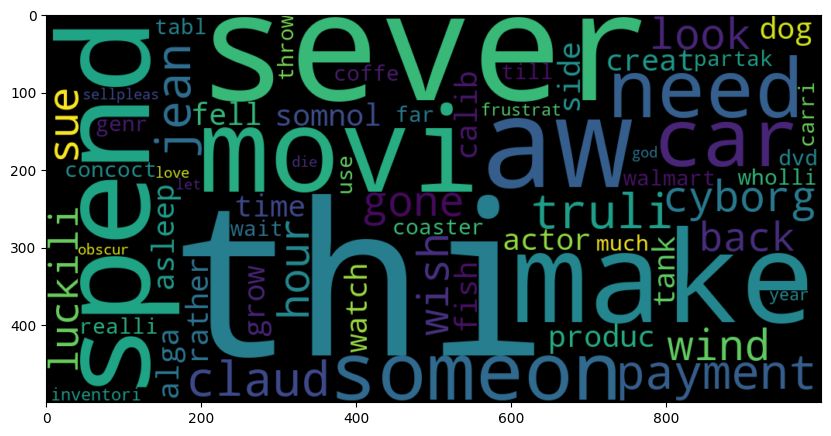

In [82]:
#word cloud for positive review words
plt.figure(figsize=(10,10))
positive_text=norm_train_reviews[1]
WC=WordCloud(width=1000,height=500,max_words=500,min_font_size=5)
positive_words=WC.generate(positive_text)
plt.imshow(positive_words,interpolation='bilinear')
plt.show

<function matplotlib.pyplot.show(close=None, block=None)>

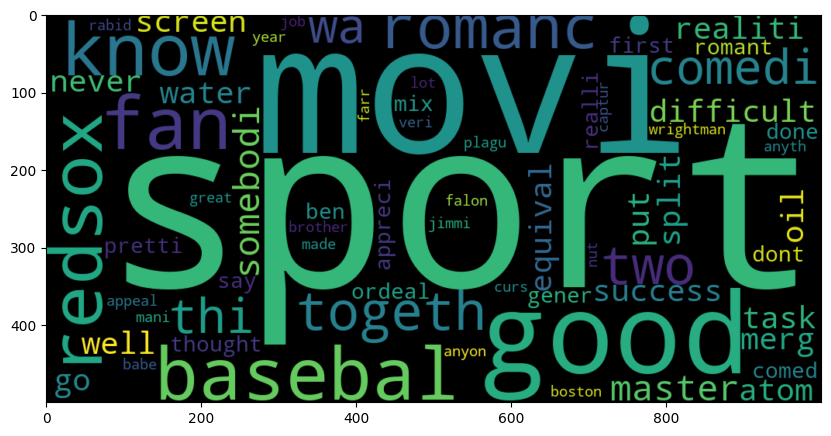

In [83]:
#Word cloud for negative review words
plt.figure(figsize=(10,10))
negative_text=norm_train_reviews[8]
WC=WordCloud(width=1000,height=500,max_words=500,min_font_size=5)
negative_words=WC.generate(negative_text)
plt.imshow(negative_words,interpolation='bilinear')
plt.show